In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pandas as pd
from zipfile import ZipFile



In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp "./gdrive/MyDrive/Colab Notebooks/Data/kaggle-proyectos.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


# Descargamos y descomprimimos el dataset
!kaggle datasets download -d compiladoresdani/spacenet-processed
!kaggle datasets download -d atilol/aerialimageryforroofsegmentation


100% 7.20G/7.21G [03:04<00:00, 79.6MB/s]
100% 7.21G/7.21G [03:04<00:00, 41.9MB/s]
100% 17.4G/17.4G [06:01<00:00, 78.0MB/s]
100% 17.4G/17.4G [06:01<00:00, 51.7MB/s]


In [ ]:
img_width, img_height = 512, 512
input_shape = (img_width, img_height, 3)
input_zip_paths = {
    'spacenet': "spacenet-processed.zip",
     'airs' : 'aerialimageryforroofsegmentation.zip'
     }
batch_size = 16

# Data Generator

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2

# Codigo de: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, input_zips, batch_size=32, dim_features=(512,512,3), dim_labels=(512,512,1), n_channels=1, shuffle=True, augmentation=None):
        self.dim_features = dim_features
        self.dim_labels = dim_labels
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.input_zips = input_zips
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        # Número de batches por epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Genera un batch
        # Genera índices del batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Busca los IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Genera los datos
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        # Actualiza los índices despues de cada epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Genera los datos con batch_size elementos' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim_features))
        Y = np.empty((self.batch_size, *self.dim_labels))


        # Genera los datos
        for (i, (zip_file, img_path, msk_path)) in enumerate(list_IDs_temp):
            # Guarda un sample
            img = cv2.cvtColor(cv2.imdecode(np.frombuffer(self.input_zips.get(zip_file).read(img_path), np.uint8), cv2.IMREAD_COLOR), cv2.COLOR_RGB2BGR)

            # Guarda la clase del ejemplo
            msk = cv2.imdecode(np.frombuffer(self.input_zips.get(zip_file).read(msk_path), np.uint8), cv2.IMREAD_GRAYSCALE)
                        
            X[i,] = cv2.resize(img, self.dim_features[:2])
            temp = cv2.resize(msk, self.dim_labels[:2])
            temp[temp>0]=1
            Y[i,] = temp
        X, Y = self.augmentation((X, Y))


        return X, Y

# DataAugmentation

In [ ]:
import zipfile
from PIL import Image
import random
from pprint import pprint

input_zips = {
    'spacenet': ZipFile(input_zip_paths.get('spacenet'), mode='a', compression=zipfile.ZIP_STORED),
    'airs' : ZipFile(input_zip_paths.get('airs'), mode='a', compression=zipfile.ZIP_STORED)
}


#print(input.printdir())

input_directories_spacenet = (
 'AOI_2_Vegas_Train_Processed/',
 'AOI_3_Paris_Train_Processed/',
 'AOI_4_Shanghai_Train_Processed/',         
 'AOI_5_Khartoum_Train_Processed/',
)

discard_files_ending_spacenet = (
    'segobj.png',
    'segobj.tif',
    'segcls.png',
    'segcls.tif',
    '.xml',
)


input_files_spacenet = [ filename for filename in input_zips.get('spacenet').namelist() if filename.startswith(input_directories_spacenet)]
input_files_spacenet = [ filename for filename in input_files_spacenet if not filename.endswith(discard_files_ending_spacenet)]


def get_label_file(feature_file):
  return "".join(feature_file.rsplit('.', 1)[:-1]) + 'segobj.tif'

input_files = [('spacenet', filename, get_label_file(filename)) for filename in input_files_spacenet]

#pprint(random.sample(input_files, 10))
#list(set([os.path.dirname(x) for x in input.namelist()]))
random.Random(1).shuffle(input_files)

train_samples = input_files[:int((len(input_files)+1)*.80)]
test_samples = input_files[int((len(input_files)+1)*.80):]

val_samples = train_samples[int((len(train_samples)+1)*.80):]
train_samples = train_samples[:int((len(train_samples)+1)*.80)]

# Agregamos el dataset AIRS que ya está dividido por carpetas

def get_label_file_airs(feature_file):
  filename_split = feature_file.split('/')
  filename = filename_split[-1]
  folder = filename_split[-3]

  return folder + '/label/' + filename


# Uncomment to use airs dataset
'''
train_samples.extend([('airs', filename, get_label_file_airs(filename)) 
                          for filename in input_zips.get('airs').namelist()
                          if filename.startswith('train/image/')
                      ])

test_samples.extend([('airs', filename, get_label_file_airs(filename)) 
                          for filename in input_zips.get('airs').namelist()
                          if filename.startswith('test/image/')
                      ])


val_samples.extend([('airs', filename, get_label_file_airs(filename)) 
                          for filename in input_zips.get('airs').namelist()
                          if filename.startswith('val/image/')
                      ])
'''

print('Datos totales: ' + str(len(input_files)))

print('Datos de entrenamiento: ' + str(len(train_samples)))
print('Datos de validación: ' + str(len(val_samples)))
print('Datos de test: ' + str(len(test_samples)))

Datos totales: 10593
Datos de entrenamiento: 6780
Datos de validación: 1695
Datos de test: 2118


### Capas de augmentation
Resizing (al tamaño del input de la red)
Rescaling (solo para las features)
RandomFlip (horizontal y vertical)
RandomRotation (de 0.2)
RandomContrast (de 0.5)
RandomZoom ((-0.1, 0.05),(-0.1, 0.05))
    

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import tensorflow as tf

dataset_gen_seed = random.random()

def Augment(seed=dataset_gen_seed):
    img = tf.keras.Input(shape=(None,None,3), dtype="uint8")
    msk = tf.keras.Input(shape=(None,None,1), dtype="uint8")

    i = tf.keras.layers.Resizing(img_width, img_height)(img)
    m = tf.keras.layers.Resizing(img_width, img_height,dtype="uint8")(msk)

    i = tf.keras.layers.Rescaling(1./255)(i)
    #m = tf.keras.layers.Rescaling(1./255)(m)

    i = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=seed)(i)
    m = tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=seed,dtype="uint8")(m)

    i = tf.keras.layers.RandomRotation(0.2, seed=seed)(i)
    m = tf.keras.layers.RandomRotation(0.2, seed=seed,dtype="uint8")(m)

    i = tf.keras.layers.RandomContrast(0.1, seed=seed)(i)
    #m = tf.keras.layers.RandomContrast(0.5, seed=seed)(m)

    #i = tf.keras.layers.RandomTranslation(height_factor=0.3,width_factor=0.3,fill_mode="reflect",interpolation="bilinear",fill_value=0.0, seed=seed)(i)
    #m = tf.keras.layers.RandomTranslation(height_factor=0.3,width_factor=0.3,fill_mode="reflect",interpolation="bilinear",fill_value=0.0, seed=seed)(m)

    i = tf.keras.layers.RandomZoom((-0.1, 0.05),(-0.1, 0.05),seed=seed)(i)
    m = tf.keras.layers.RandomZoom((-0.1, 0.05),(-0.1, 0.05),seed=seed,dtype="uint8")(m)
    
    return tf.keras.Model(inputs=(img,msk), outputs=(i,m))

augmentation = Augment()

params = {
          'dim_features': (img_width, img_height, 3),
          'dim_labels': (img_width, img_height),
          'batch_size': batch_size,
          'shuffle': True,
          'augmentation': augmentation,
          }



# Generadores
train_generator = DataGenerator(train_samples, input_zips, **params)
val_generator = DataGenerator(val_samples, input_zips, **params)
test_generator = DataGenerator(test_samples, input_zips, **params)





In [ ]:
augmentation.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 resizing (Resizing)            (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['resizing[0][0]']               
                                                                                                  
 input_2 (InputLayer)           [(None, None, None,  0           []                           

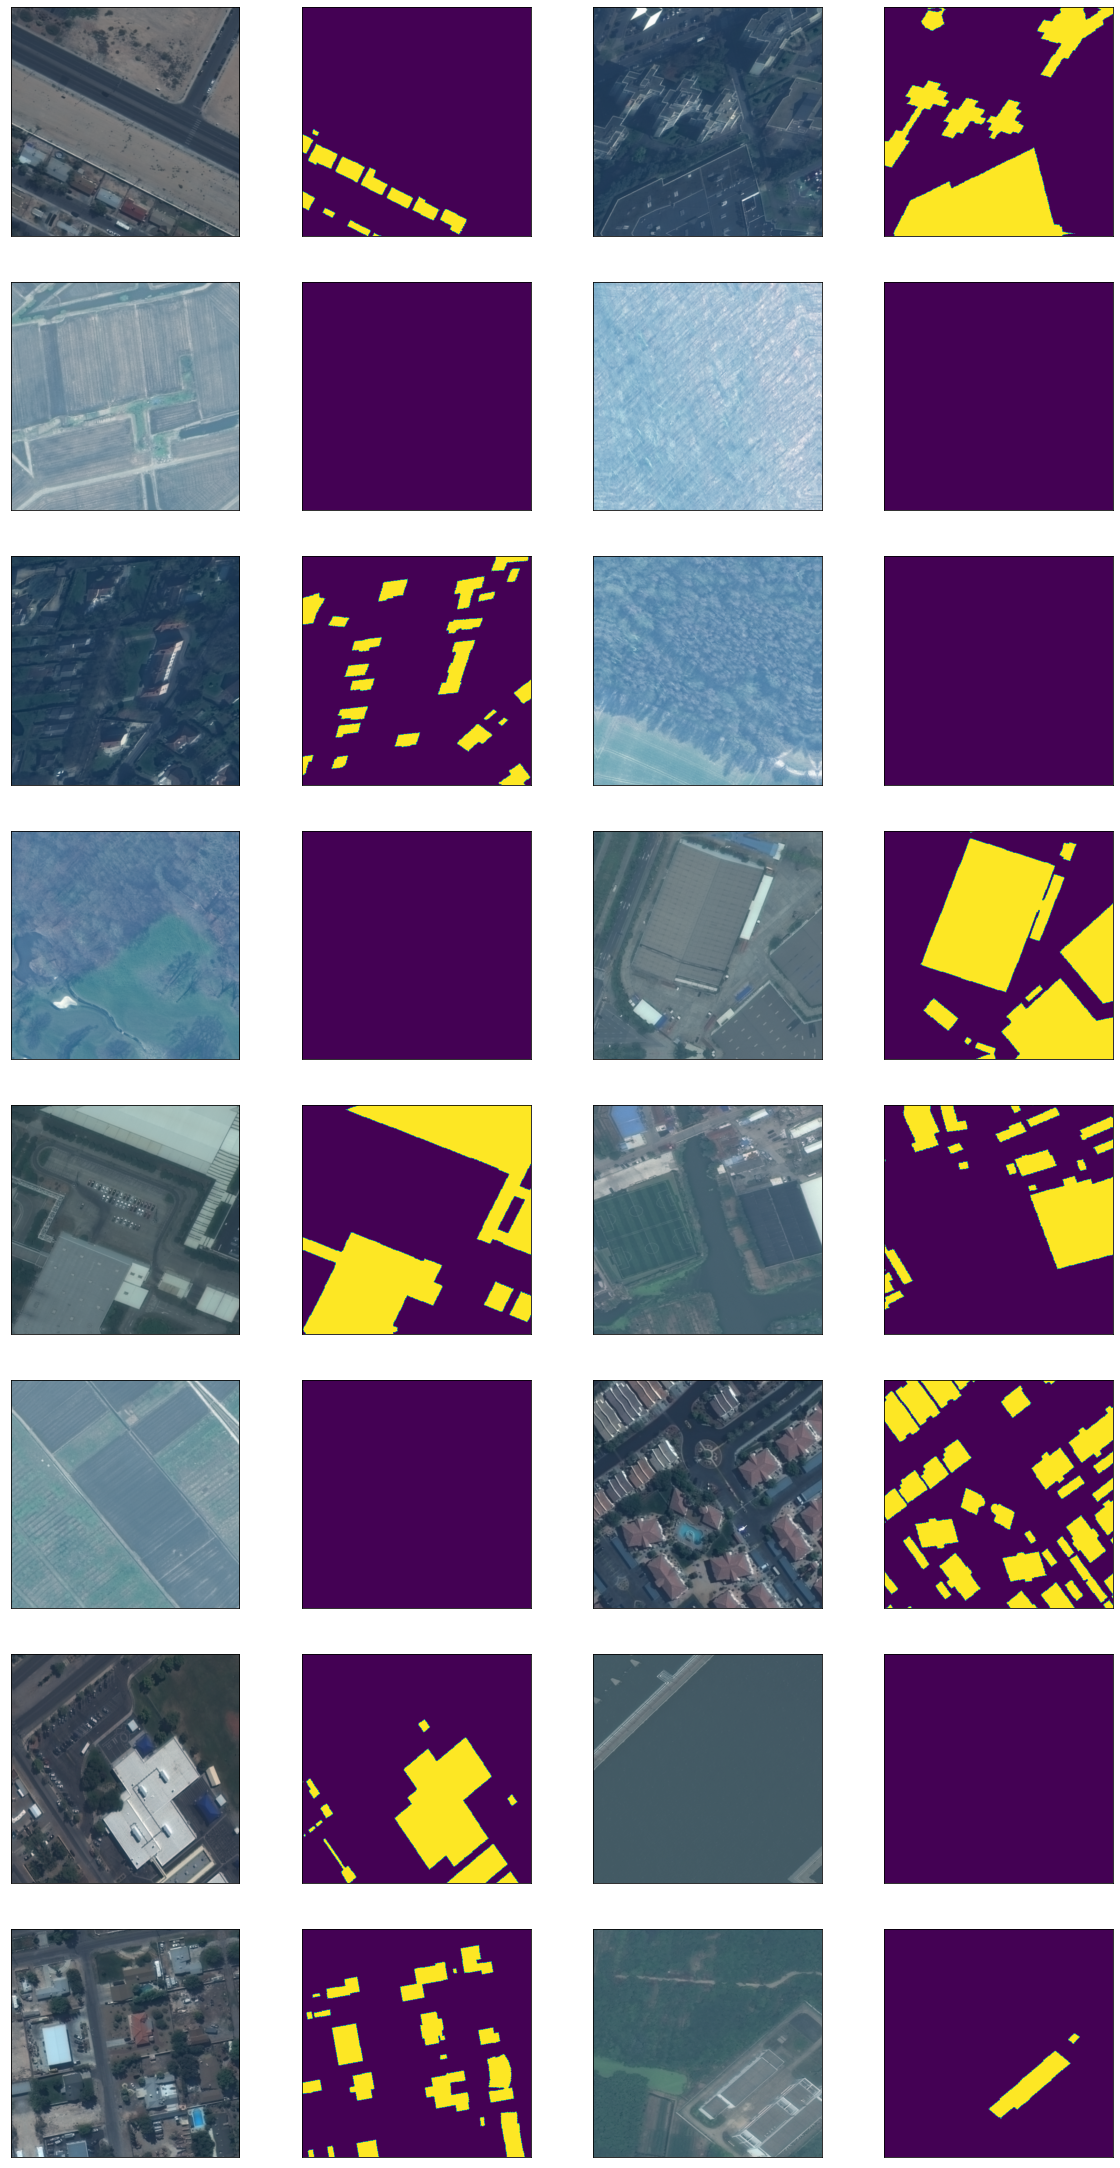

In [ ]:
sample_size = (batch_size * 2) + 1 
cols = 4
rows = (sample_size * 2 // cols) + 1
plt.figure(figsize=(cols * 5, rows * 5))

test_images, test_masks = next(iter(train_generator))

for i in range(len(test_images)):
  plt.subplot(rows, cols, i * 2 + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_images[i])
  plt.subplot(rows, cols, i * 2 + 2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_masks[i][:,:,0])

# Callbacks del modelo


In [ ]:
from keras import backend as K

'''def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)'''

'def mean_iou(y_true, y_pred):\n    prec = []\n    for t in np.arange(0.5, 1.0, 0.05):\n        y_pred_ = tf.cast(y_pred > t, tf.int32)\n        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)\n        K.get_session().run(tf.local_variables_initializer())\n        with tf.control_dependencies([up_opt]):\n            score = tf.identity(score)\n        prec.append(score)\n    return K.mean(K.stack(prec), axis=0)'

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


callbacks = [
  ModelCheckpoint(
       './gdrive/MyDrive/modelos_ml/proyectos-multiresunet-airs/PRE-{val_accuracy:03f}-{val_mean_io_u:03f}-({epoch:02d}).h5',
       monitor = 'val_accuracy',
       mode = 'max',
       save_best_only = True,
       verbose=1
  ),

  ReduceLROnPlateau(
       monitor = 'val_accuracy', 
       patience = 12,
       factor = 0.9,
       mode = 'max',
       verbose=1
  ),

  #EarlyStopping(
   #    monitor = 'val_mean_io_u',
   #    patience = 10,
   #    mode = 'max',
   #    verbose=1
  #), 
]

# Modelo

In [ ]:
from keras import backend as K

#mean_iou =tf.keras.metrics.MeanIoU(num_classes=2)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.keras.metrics.MeanIoU(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)




In [ ]:
from tensorflow.keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_score


def create_model(): 
  inputs = Input((img_height, img_width, 3))

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

  return model


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model



def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    filters_base = 8

    mresblock1 = MultiResBlock(filters_base, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(filters_base, 4, mresblock1)

    mresblock2 = MultiResBlock(filters_base*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(filters_base*2, 3, mresblock2)

    mresblock3 = MultiResBlock(filters_base*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(filters_base*4, 2, mresblock3)

    mresblock4 = MultiResBlock(filters_base*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(filters_base*8, 1, mresblock4)

    mresblock5 = MultiResBlock(filters_base*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        filters_base*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(filters_base*8, up6)

    up7 = concatenate([Conv2DTranspose(
        filters_base*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(filters_base*4, up7)

    up8 = concatenate([Conv2DTranspose(
        filters_base*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(filters_base*2, up8)

    up9 = concatenate([Conv2DTranspose(filters_base, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(filters_base, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

    return model
   



In [ ]:
model = create_model()

In [ ]:
model = MultiResUnet(img_height, img_width, 3)

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/modelos_ml/proyectos-multiresunet-airs/checkpoint.hdf5')

In [ ]:

results = model.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=batch_size,
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/150
423/423 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9370 - mean_io_u: 0.4260
Epoch 1: val_accuracy improved from 0.86674 to 0.93664, saving model to ./gdrive/MyDrive/modelos_ml/proyectos-multiresunet-airs/PRE-0.936636-0.427678-(01).h5
423/423 [==============================] - 581s 1s/step - loss: 0.1957 - accuracy: 0.9370 - mean_io_u: 0.4260 - val_loss: 0.2044 - val_accuracy: 0.9366 - val_mean_io_u: 0.4277 - lr: 4.7101e-05
Epoch 2/150
423/423 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9358 - mean_io_u: 0.4260
Epoch 2: val_accuracy did not improve from 0.93664
423/423 [==============================] - 574s 1s/step - loss: 0.1960 - accuracy: 0.9358 - mean_io_u: 0.4260 - val_loss: 0.2066 - val_accuracy: 0.9344 - val_mean_io_u: 0.4273 - lr: 4.7101e-05
Epoch 3/150
423/423 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9370 - mean_io_u: 0.4259
Epoch 3: val_accuracy did not improve from 0.93664
423

# Watershed

In [ ]:
test_generator_iter = iter(test_generator)

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

sample_size = (batch_size * 4) + 1 
cols = 4
rows = (sample_size * 4 // cols) + 1
plt.figure(figsize=(cols * 5, rows * 5))

test_images, test_masks = next(test_generator_iter)
predictions = model.predict(test_images, batch_size=batch_size)


for i in range(len(test_images)):
  prediction = predictions[i]
  prediction[prediction>0.5]=255
  prediction[prediction<=0.5]=0

  prediction_watershet_gray = np.copy(prediction)
  prediction_watershet_gray = prediction_watershet_gray.astype(np.uint8)
  #prediction_watershet_gray = np.reshape(prediction_watershet_gray, (prediction_watershet_gray.shape[0], prediction_watershet_gray.shape[1], 3))

  prediction_watershet = cv.cvtColor(prediction_watershet_gray,cv.COLOR_GRAY2BGR)

  ret, thresh = cv.threshold(prediction_watershet_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  # noise removal
  kernel = np.ones((3,3),np.uint8)
  opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 5)
  # sure background area
  sure_bg = cv.dilate(opening,kernel,iterations=1)
  # Finding sure foreground area
  dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
  ret, sure_fg = cv.threshold(dist_transform,0.25*dist_transform.max(),255,0) # Tunear el multiplicador segun el zoom
  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv.subtract(sure_bg,sure_fg)


  # Marker labelling
  ret, markers = cv.connectedComponents(sure_fg)
  # Add one to all labels so that sure background is not 0, but 1
  markers = markers+1
  # Now, mark the region of unknown with zero
  markers[unknown==255] = 0

  markers = cv.watershed(prediction_watershet,markers)
  prediction_watershet[markers == -1] = [255,0,0]

  plt.subplot(rows, cols, i * 4 + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_images[i])
  plt.subplot(rows, cols, i * 4 + 2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(prediction[:,:,0])
  plt.subplot(rows, cols, i * 4 + 3)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(markers)
  plt.subplot(rows, cols, i * 4 + 4)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(prediction_watershet)




#Exportación del modelo

In [ ]:
!pip install tensorflowjs[wizard]


     |████████████████████████████████| 77 kB 3.8 MB/s 
     |████████████████████████████████| 248 kB 19.5 MB/s 
     |████████████████████████████████| 462 kB 45.8 MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-py3-none-any.whl size=32863 sha256=7d9f14fdedbd192192dcbc27ff4b765bfacf0706b36c4d6db9887b184e59e81c
  Stored in directory: /root/.cache/pip/wheels/89/3b/7b/8b3cc8ac47137eabaeb6937a3ff0d33e78a12e2ba1e3ad4ba1
Successfully built PyInquirer
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


In [ ]:
model.save('/content/gdrive/MyDrive/modelos_ml/proyectos-multiresunet-airs/checkpoint.hdf5')

In [ ]:


model.save('/content/model.hdf5')
!tensorflowjs_converter \
    --input_format=keras \
    /content/model.hdf5 \
    /content/model_js.json

# Visualización de predicciones sobre el conjunto de validación

In [ ]:
model.evaluate(test_generator)

138/138 [==============================] - 269s 2s/step - loss: 0.1998 - accuracy: 0.9332 - mean_io_u: 0.4289


[0.19976088404655457, 0.933208167552948, 0.42893651127815247]

In [ ]:
test_generator_iter = iter(test_generator)

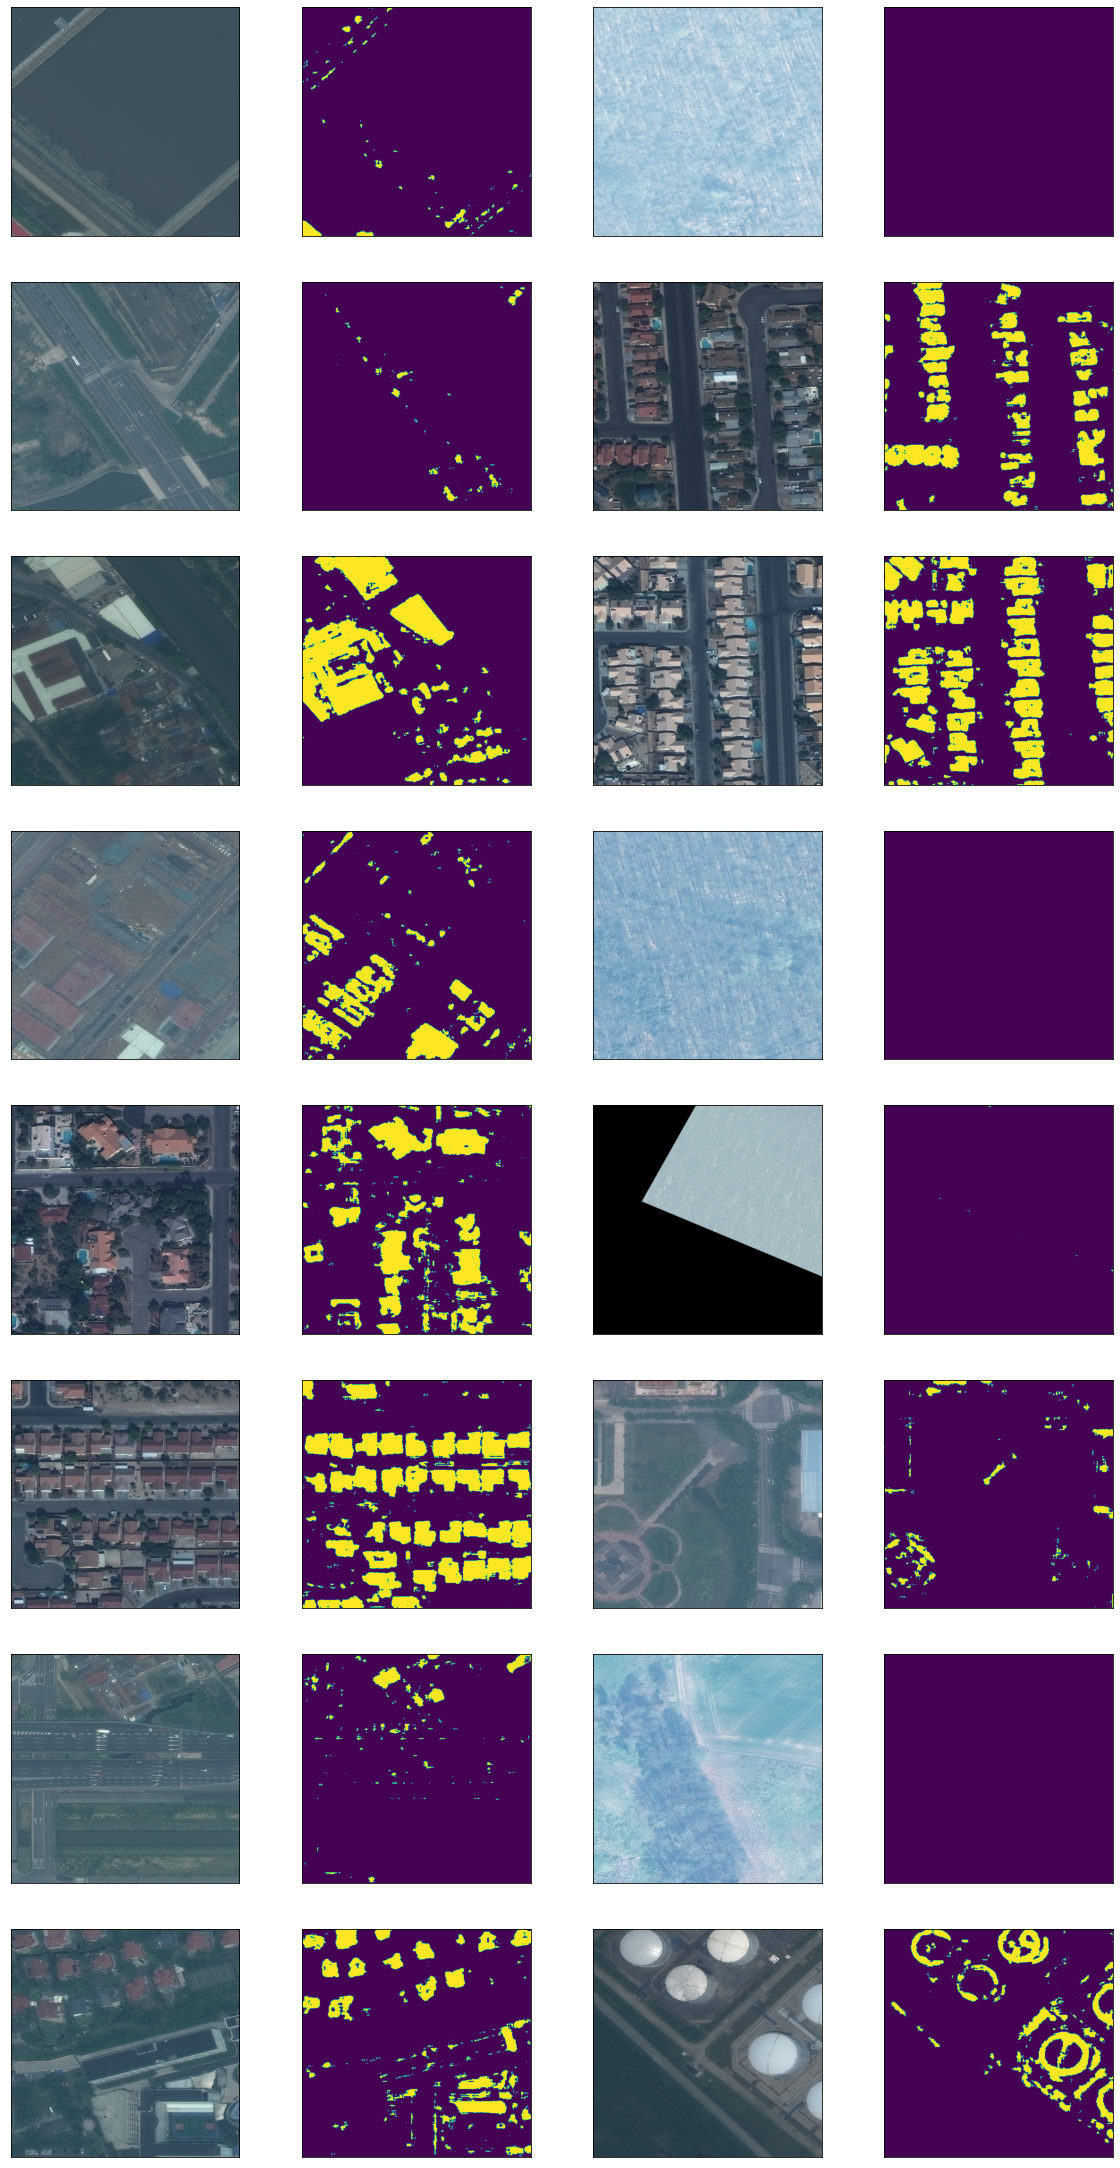

In [ ]:
'''plt.figure(figsize=(10, 10))

test_images, test_masks = next(iter(test_generator))
for i in range(16):
  img = test_images
  prediction = np.argmax(model.predict(img, batch_size=1)[0])
  plt.subplot(4, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(test_masks[i][:,:,0])'''
'''sample_size = (batch_size * 2) + 1 tyjn
cols = 
rows = (sample_size * 2 // cols) + 1
plt.figure(figsize=(cols * 5, rows * 5))

test_images, test_masks = next(iter(train_generator))
print(np.amax(test_masks))

for i in range(len(test_images)):
  print(np.amax(test_masks[i]))
  plt.subplot(rows, cols, i * 2 + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_images[i])
  plt.subplot(rows, cols, i * 2 + 2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_masks[i][:,:,0])'''

sample_size = (batch_size * 2) + 1 
cols = 4
rows = (sample_size * 2 // cols) + 1
plt.figure(figsize=(cols * 5, rows * 5))

test_images, test_masks = next(test_generator_iter)

predictions = model.predict(test_images, batch_size=batch_size)
for i in range(len(test_images)):
  prediction = predictions[i]
  prediction[prediction>0.5]=1
  prediction[prediction<=0.5]=0
  plt.subplot(rows, cols, i * 2 + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_images[i])
  plt.subplot(rows, cols, i * 2 + 2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(prediction[:,:,0])

# Visualización de predicciones sobre el conjunto de test (rendimiento real)